# Analysis of the Adult data set from UCI Machine Learning Repository

This is an analysis of the [Adult data set](http://archive.ics.uci.edu/ml/datasets/Adult) in the UCI Machine Learning Repository.

This data set is meant for binary class classification - to predict whether the income of a person exceeds 50K per year based on some census data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Preliminaries

First, we import the necessary libraries:

In [0]:
from IPython.display import display
from numpy.random import RandomState
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler


import numpy as np
import pandas as pd

We create a numpy.random.RandomState so that we can reproduce the same results each time we run this notebook.

In [0]:
rs = RandomState(121)

## Exploratory Data Analysis

This dataset is small and consists of 48842 rows with 14 columns (not counting the column giving the response variable). Hence we can load it entirely into memory. The fields of this data set are delimited by spaces; we can make use of pandas `read_csv` function to load it into memory as a dataframe.

In [0]:
X = pd.read_csv("/content/drive/My Drive/Veri Bilimi Ödev1/Dataset.txt", header=None, delimiter=r"\s+",)

Let's take a look at the first few rows of the dataframe.

In [5]:
print(X.head())

   0          1       2             3   ...   11    12             13     14
0  25    Private  226802          11th  ...  0.0  40.0  United-States  <=50K
1  38    Private   89814       HS-grad  ...  0.0  50.0  United-States  <=50K
2  28  Local-gov  336951    Assoc-acdm  ...  0.0  40.0  United-States   >50K
3  44    Private  160323  Some-college  ...  0.0  40.0  United-States   >50K
4  18          ?  103497  Some-college  ...  0.0  30.0  United-States  <=50K

[5 rows x 15 columns]


Seems like everything is as according to the specifications. For ease of human consumption, we assign column names to the dataframe based on the specs.

In [0]:
X.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

See if there are any NaNs in the dataframe:

In [7]:
X.isnull().values.any()

True

Let's show the first few rows of the dataframe with the column names:

In [8]:
print(X.head())

   Age  WorkClass  fnlwgt  ... HoursPerWeek  NativeCountry Income
0   25    Private  226802  ...         40.0  United-States  <=50K
1   38    Private   89814  ...         50.0  United-States  <=50K
2   28  Local-gov  336951  ...         40.0  United-States   >50K
3   44    Private  160323  ...         40.0  United-States   >50K
4   18          ?  103497  ...         30.0  United-States  <=50K

[5 rows x 15 columns]


Let's take a look at the values of the `Income` column:

In [0]:
#y = X["Income"].values
y= X["Income"].copy()
X.drop("Income", axis=1, inplace=True,)

Let's look at the data again:

In [10]:
print(X.head())

   Age  WorkClass  fnlwgt  ... CapitalLoss  HoursPerWeek  NativeCountry
0   25    Private  226802  ...         0.0          40.0  United-States
1   38    Private   89814  ...         0.0          50.0  United-States
2   28  Local-gov  336951  ...         0.0          40.0  United-States
3   44    Private  160323  ...         0.0          40.0  United-States
4   18          ?  103497  ...         0.0          30.0  United-States

[5 rows x 14 columns]


Now, the `Age`, `fnlwgt`, `EducationNum`, `CapitalGain`, `CapitalLoss` and `HoursPerWeek` are clearly numerical. Let's get some summary statistics on these numerical columns:

In [11]:
X.describe()

,Age,fnlwgt,EducationNum,CapitalGain,CapitalLoss,HoursPerWeek
count,8530.000000,8.530000e+03,8530.000000,8529.000000,8529.000000,8529.000000
mean,38.693552,1.882292e+05,10.060492,1128.986165,87.251847,40.436042
std,13.803450,1.051589e+05,2.574321,7903.709643,401.969239,12.429715
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.156770e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.779815e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.374818e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3175.000000,99.000000


In [12]:
X.dtypes

Age                int64
WorkClass         object
fnlwgt             int64
Education         object
EducationNum       int64
MaritalStatus     object
Occupation        object
Relationship      object
Race              object
Gender            object
CapitalGain      float64
CapitalLoss      float64
HoursPerWeek     float64
NativeCountry     object
dtype: object

Let's convert the `Age`, `fnlwgt`, `EducationNum` and `HoursPerWeek` to floating point so scikit-learn / numpy won't complain about scaling later.

In [0]:
X.Age = X.Age.astype(float)
X.fnlwgt = X.fnlwgt.astype(float)
X.EducationNum = X.EducationNum.astype(float)
X.HoursPerWeek = X.HoursPerWeek.astype(float)

In [14]:
y.shape

(8530,)

In [15]:
X.shape

(8530, 14)

In [16]:
X

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8525,23.0,Private,130959.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,2407.0,0.0,6.0,Canada
8526,51.0,Private,158746.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,1902.0,60.0,United-States
8527,29.0,Private,498833.0,HS-grad,9.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,0.0,0.0,40.0,Nicaragua
8528,46.0,Private,193188.0,Masters,14.0,Never-married,Exec-managerial,Unmarried,White,Male,0.0,0.0,40.0,United-States


# Start from here!

# Pre Processing

In [0]:
X = pd.concat([X, y], axis=1)

In [18]:
X.isin(['?']).sum()

Age                0
WorkClass        515
fnlwgt             0
Education          0
EducationNum       0
MaritalStatus      0
Occupation       515
Relationship       0
Race               0
Gender             0
CapitalGain        0
CapitalLoss        0
HoursPerWeek       0
NativeCountry    137
Income             0
dtype: int64

In [19]:
X = X.replace('?', np.NaN)
X.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


In [20]:
X = X.dropna()
X

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
5,34.0,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8524,73.0,Private,159007.0,Bachelors,13.0,Divorced,Farming-fishing,Other-relative,White,Female,0.0,0.0,12.0,United-States,<=50K
8525,23.0,Private,130959.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,2407.0,0.0,6.0,Canada,<=50K
8526,51.0,Private,158746.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,1902.0,60.0,United-States,>50K
8527,29.0,Private,498833.0,HS-grad,9.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,0.0,0.0,40.0,Nicaragua,<=50K


In [21]:
X['Income'] = X['Income'].map({'<=50K':0, '>50K':1})

X.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1
5,34.0,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,0


In [0]:
#X.drop(["Occupation","Relationship","Race","NativeCountry"], axis=1, inplace=True,)
#X.head()

In [0]:
X['Gender'] = X['Gender'].map({'Male':0, 'Female':1})


In [24]:

X.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,0,0.0,0.0,40.0,United-States,0
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,0,0.0,0.0,50.0,United-States,0
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,0,0.0,0.0,40.0,United-States,1
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,0,7688.0,0.0,40.0,United-States,1
5,34.0,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,0,0.0,0.0,30.0,United-States,0


In [25]:
X['MaritalStatus'].unique()

array(['Never-married', 'Married-civ-spouse', 'Widowed', 'Separated',
       'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [0]:
X['MaritalStatus'] = X['MaritalStatus'].replace(['Widowed', 'Divorced', 'Separated', 'Never-married'], 'Single')

X['MaritalStatus'] = X['MaritalStatus'].replace(['Married-spouse-absent', 'Married-civ-spouse', 'Married-AF-spouse'], 'Married')
X["MaritalStatus"] = X["MaritalStatus"].map({"Married":1, "Single":0})
X["MaritalStatus"] = X["MaritalStatus"].astype(int)

In [0]:
from sklearn.preprocessing import LabelEncoder


In [0]:
y = X['Income']
X = X.drop(['Income'], axis=1)


X_encoded = pd.get_dummies(X, prefix_sep="_")
y_encoded = LabelEncoder().fit_transform(y)
X_scaled = StandardScaler().fit_transform(X_encoded)


# HAZIRLIK


In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.svm import SVC
import time
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.30, random_state=41)

In [31]:
start = time.process_time()
model=RandomForestClassifier().fit(X_train,y_train)
print(time.process_time() - start)

preds = model.predict(X_test)

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

0.7064399699999999
[[1658  137]
 [ 257  315]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1795
           1       0.70      0.55      0.62       572

    accuracy                           0.83      2367
   macro avg       0.78      0.74      0.75      2367
weighted avg       0.82      0.83      0.83      2367



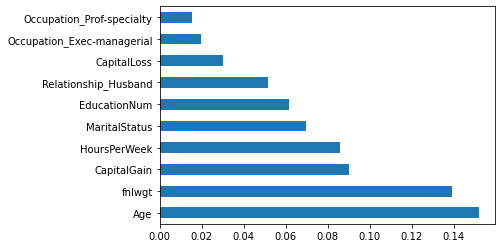

In [32]:
feature_imp = pd.Series(model.feature_importances_, index= X_encoded.columns)
feature_imp.nlargest(10).plot(kind='barh')

In [33]:
best_feat = feature_imp.nlargest(6).index.to_list()

X_reduced = X_encoded[feature_imp.nlargest(6).index]
Xr_scaled = StandardScaler().fit_transform(X_reduced)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr_scaled, y, test_size = 0.30, 
                                                        random_state = 41)

start = time.process_time()
model=RandomForestClassifier().fit(X_train,y_train)
print(time.process_time() - start)

preds = model.predict(X_test)

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

0.6958117969999993
[[1654  141]
 [ 258  314]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1795
           1       0.69      0.55      0.61       572

    accuracy                           0.83      2367
   macro avg       0.78      0.74      0.75      2367
weighted avg       0.82      0.83      0.82      2367



In [34]:
Xr_scaled

array([[-1.02096555,  0.36689371, -0.14596657, -0.0844416 , -0.94053994,
        -1.21253268],
       [-0.04574794, -0.93686908, -0.14596657,  0.74649242,  1.06321907,
        -0.43191653],
       [-0.79591533,  1.41522034, -0.14596657, -0.0844416 ,  1.06321907,
         0.7390077 ],
       ...,
       [ 0.92946966, -0.28081909, -0.14596657,  1.57742645,  1.06321907,
         1.12931577],
       [-0.72089859,  2.95590806, -0.14596657, -0.0844416 ,  1.06321907,
        -0.43191653],
       [ 0.55438597,  0.0469775 , -0.14596657, -0.0844416 , -0.94053994,
         1.51962385]])

# SVM Classifier (SVC)

* Classifier 1 - Optimization (Use 5-fold Stratified CV with random_state= 41)
* After applying GridSearchCV to find the best parameters for your data, CREATE AN INSTANCE OF YOUR CLASSIFIER with the best parameters! 


In [0]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr_scaled, y, test_size = 0.1, 
                                                        random_state = 41)

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

clf = SVC()
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

grid_values = {'gamma': [0.001, 0.01, 0.05, 0.1], 'kernel': ['linear', 'rbf'], 'max_iter': [-5,-1,0,1,5], 'decision_function_shape': ['ovo','ovr'], 'random_state': [41], 'C': [1.0,700.0]}

# default metric to optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, cv= 5)

grid_clf_acc.fit(Xr_train, yr_train)

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=-5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=-5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=-5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=-5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:

Grid best parameter (max. accuracy):  {'C': 1.0, 'decision_function_shape': 'ovo', 'gamma': 0.05, 'kernel': 'rbf', 'max_iter': -1, 'random_state': 41}
Grid best score (accuracy):  0.8323943661971832


In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

clf = SVC()
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

grid_values = {'gamma': [0.001, 0.01, 0.05, 0.1], 'kernel': ['linear', 'rbf'], 'max_iter': [-5,-1,0,1,5], 'decision_function_shape': ['ovo','ovr'], 'random_state': [41], 'C': [1.0,700.0]}

# default metric to optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, cv= 5)

grid_clf_acc.fit(Xr_scaled, y)

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=-5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=-5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=-5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=-5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:

KeyboardInterrupt: ignored

# NB Classifier

* Classifier 2 - Optimization (Use 5-fold Stratified CV with random_state= 41)
* After applying GridSearchCV to find the best parameters for your data, CREATE AN INSTANCE OF YOUR CLASSIFIER with the best parameters! 

In [0]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr_scaled, y, test_size = 0.1, 
                                                        random_state = 41)

In [0]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()



grid_values = {'var_smoothing': [1e-9,1e-11,1e-7,1e-5,1e-15,1e-8]}

# default metric to optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, cv= 5)

grid_clf_acc.fit(Xr_scaled, y)

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

Grid best parameter (max. accuracy):  {'var_smoothing': 1e-09}
Grid best score (accuracy):  0.7917344784380669


* Comparison of the two classifiers: (Make comparison based on the results of 5-fold Stratified CV with random_state= 41)

In [0]:
from sklearn.naive_bayes import GaussianNB

In [0]:
from sklearn import model_selection
 

models=[]
models.append(('SVM', SVC(C= 1.0, decision_function_shape= 'ovo', gamma= 0.05, kernel= 'rbf', max_iter= -1 )))
models.append(('NB', GaussianNB(var_smoothing = 1e-09)))

# evaluate each model
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=41)
    cv_results = model_selection.cross_val_score(model, Xr_scaled, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.832930 (0.008961)
NB: 0.791609 (0.004661)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


# Ödev 2

In [0]:
# https://medium.com/fintechexplained/lets-talk-about-machine-learning-ensemble-learning-in-python-382747e5fba8
# https://towardsdatascience.com/ensemble-learning-using-scikit-learn-85c4531ff86a

# KNN

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
grid_values = {'n_neighbors': np.arange(1, 25)}

kfold = model_selection.KFold(n_splits=5, random_state=123)


grid_clf_acc = GridSearchCV(knn, param_grid = grid_values, cv= kfold)

grid_clf_acc.fit(Xr_scaled, y)

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Grid best parameter (max. accuracy):  {'n_neighbors': 15}
Grid best score (accuracy):  0.8287488959238998


In [0]:
#save best model
knn_best = grid_clf_acc.best_estimator_

# Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
#create a new random forest classifier
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
grid_values = {'n_estimators': [50, 100, 200]}

kfold = model_selection.KFold(n_splits=5, random_state=123)


grid_clf_acc = GridSearchCV(rf, param_grid = grid_values, cv= kfold)

grid_clf_acc.fit(Xr_scaled, y)

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Grid best parameter (max. accuracy):  {'n_estimators': 200}
Grid best score (accuracy):  0.8244374737292175


In [0]:
#save best model
rf_best = grid_clf_acc.best_estimator_

# Lojistik Regresyon

In [40]:
from sklearn.linear_model import LogisticRegression
#create a new logistic regression model
log_reg = LogisticRegression()

grid_values = {'solver': ['newton-cg', 'lbfgs','sag'], 'penalty':['l2'], 'C':[1.0, 5.0, 50.0, 100.0,0.5,0.1]}

kfold = model_selection.KFold(n_splits=5, random_state=123)


grid_clf_acc = GridSearchCV(log_reg, param_grid = grid_values, cv= kfold)

grid_clf_acc.fit(Xr_scaled, y)

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Grid best parameter (max. accuracy):  {'C': 0.5, 'penalty': 'l2', 'solver': 'newton-cg'}
Grid best score (accuracy):  0.8283669800273739


In [0]:
#save best model
log_Reg_best = grid_clf_acc.best_estimator_

# Adaboost


In [42]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
import numpy as np

kfold = model_selection.KFold(n_splits=5, random_state=123)
clf = AdaBoostClassifier(n_estimators=100)

scores = cross_val_score(clf, Xr_scaled, y, cv=kfold)
scores.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.839902495714296

# Ensemble

In [0]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [0]:

#create a dictionary of our models
svc_best=SVC(C= 1.0, decision_function_shape= 'ovo', gamma= 0.05, kernel= 'rbf', max_iter= -1 )
gnb_best=GaussianNB(var_smoothing = 1e-09)
estimators=[('knn', knn_best), ('rf', rf_best), ('log_reg', log_Reg_best),('SVC',svc_best),('GNB',gnb_best),('Ada',clf)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

In [0]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr_scaled, y, test_size = 0.2, 
                                                        random_state = 123)

In [51]:
#fit model to training data
ensemble.fit(Xr_train, yr_train)
#test our model on the test data
ensemble.score(Xr_test, yr_test)

0.8238276299112801

In [0]:

#ensemble.fit(Xr_scaled, y)

#ensemble.score(Xr_scaled, y)

In [54]:
from sklearn.model_selection import cross_val_score


for model in ([knn_best, rf_best, log_Reg_best, svc_best, gnb_best, ensemble]):

  kfold = model_selection.KFold(n_splits=3, random_state=40)
  scores = cross_val_score(model, Xr_scaled, y, cv=kfold,  scoring='accuracy')
  print( "Accuracy: " , scores.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy:  0.8220309109517948


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy:  0.8245652831029161
Accuracy:  0.827607349245353


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy:  0.833565461960072
Accuracy:  0.791482928301421


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy:  0.8358475057140282
